# Installing Packages and libraries

In [ ]:
!pip install texthero
!pip install vaderSentiment
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 6.9 MB/s 
     |████████████████████████████████| 1.5 MB 48.9 MB/s 
     |████████████████████████████████| 749 kB 45.9 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend 

In [ ]:
#Importing libraries

import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import texthero as hero
import re

import matplotlib.pyplot as plt
import nltk

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize

import spacy 
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

nltk.download('punkt')


import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import os
import time
import math
import re
from pprint import pprint
from textblob import TextBlob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


import nltk as nltk
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer
import spacy
import multiprocessing
import string


import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()


import sklearn
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn import metrics

from joblib import dump, load

import warnings
warnings.filterwarnings("ignore")
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
#reading in the data
data = pd.read_json('https://storage.googleapis.com/msca-bdp-data-open/news/news_final_project.json', orient='records', lines=True)
data.head(2)

,date,language,title,text
0,2022-01-06,english,"No deal, no school: Chicago cancels classes fo...",CHICAGO (AP) — Chicago school leaders canceled...
1,2022-01-06,english,"No deal, no school: Chicago cancels classes fo...",CHICAGO (AP) — Chicago school leaders canceled...


In [ ]:
#saving the data on the drive:
# data.to_json("/content/drive/MyDrive/MScA - UChicago/Assignments/Quarter 3 - Spring 2022/NLP/Final Project/news_final_project.json")

# CLEANING DATA

We clean the the title and text for NAs, whitespace, digits, punctuations and stop words. We also split the data into 3 sections - news articles only pertaining to Chicago, only pertaining to Illinois and pertaining to both Chicago and Illinois. This should help us analyse the reasons behind people leaving by region.

In [ ]:
#cleaning the data using text hero
%%time
def clean(df, column_name):
  custom_pipeline = [hero.preprocessing.fillna,
                  hero.preprocessing.remove_whitespace,
                  hero.preprocessing.remove_digits,
                  hero.preprocessing.remove_punctuation,
                  hero.preprocessing.remove_stopwords]
  for i in column_name:
    new_col = i+'_clean'
    df[new_col] = hero.clean(df[i], custom_pipeline)

clean(data, ['title', 'text'])

CPU times: user 2min 27s, sys: 8.31 s, total: 2min 35s
Wall time: 2min 35s


In [ ]:
#original text
data.iloc[2]['text']

'Chicago PD 9×11 “Lies” Season 9 Episode 11 Promo – Voight employs his new informant to help solve a tricky drug trafficking case. Atwater, who once again struggles to reconcile his personal and professional life, reaches a decision.\n@jesseleesoffer @marinasqu @trspiridakos @NBCChicagoPD'

In [ ]:
#cleaned version by texthero
data.iloc[2]['text_clean']

'Chicago PD    Lies Season   Episode   Promo  Voight employs  new informant  help solve  tricky drug trafficking case  Atwater     struggles  reconcile  personal  professional life  reaches  decision   jesseleesoffer  marinasqu  trspiridakos  NBCChicagoPD'

In [ ]:
#Classifying articles based on whether they talk about chicago or illinois or both in the text of the news article
%%time

#lower-casing title and text so as to not miss any mention of Chicago / Illinois due to upper casing
data['lower_text_clean'] = data['text_clean'].apply(lambda x: x.lower())
data['lower_title_clean'] = data['title_clean'].apply(lambda x: x.lower())

data['combined_text'] = data['lower_text_clean'] + " " + data['lower_title_clean']

data['region'] = data['combined_text'].apply(lambda x: re.findall(r'chicago|illinois', x))
data['region'] = data['region'].apply(lambda x: list(set([word.lower() for word in x])))
data['region'] = data['region'].apply(lambda x: ' '.join(x))

#Removing all articles relating to TV episodes
data['ent'] = data['text_clean'].apply(lambda x: re.findall("[Ee]pisodes?", x))
data['ent'] = data['ent'].apply(lambda x: list(set([word.lower() for word in x])))
data['ent'] = data['ent'].apply(lambda x: ' '.join(x))

data = data.drop(['lower_text_clean', 'lower_title_clean', 'combined_text'], axis=1)

CPU times: user 16.2 s, sys: 733 ms, total: 17 s
Wall time: 17 s


<BarContainer object of 3 artists>

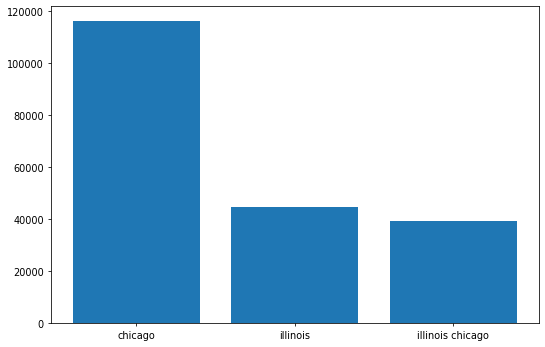

In [ ]:
# Plotting the distribution of number of records by region
fig, ax = plt.subplots(figsize=(9,6), dpi=70)
ax.bar(data['region'].value_counts().index, data['region'].value_counts())

## Running NER using Spacy

In [ ]:
#Running spacy NER
%%time

#extracting person, organisation, location and norp from the tags
person = []
org = []
gpe = []
norp = []
tags = []


for i in data['text_clean']:
  # random.shuffle(i)
  txt = i
  doc = nlp(txt)

  entities = []
  labels = []

  for ent in doc.ents:
      entities.append(ent.text)
      labels.append(ent.label_)
      # position_start.append(ent.ORG)
      # position_end.append(ent.end_char)

      df_text = pd.DataFrame({'Entities':entities,'Labels':labels})
  
  lst_people = list(df_text[df_text.Labels == "PERSON"]['Entities'])
  lst_org = list(df_text[df_text.Labels == "ORG"]['Entities'])
  lst_gpe = list(df_text[(df_text.Labels == "GPE") | (df_text.Labels == "LOC")]['Entities'])
  lst_norp = list(df_text[df_text.Labels == "NORP"]['Entities'])

  # lst_tags = [elem for elem in i if elem not in lst_people + lst_org + lst_gpe + lst_norp]

  person.append(lst_people)
  org.append(lst_org)
  gpe.append(lst_gpe)
  norp.append(lst_norp)

data['NER_people'] = person
data['NER_org'] = org
data['NER_norp'] = norp
data['NER_location'] = gpe

CPU times: user 4h 47min 28s, sys: 4min 14s, total: 4h 51min 43s
Wall time: 4h 50min 25s


In [ ]:
data.to_pickle("/content/drive/MyDrive/MScA - UChicago/Assignments/Quarter 3 - Spring 2022/NLP/Final Project/Data/data_ner.pkl")

In [ ]:
df = pd.read_pickle("/content/drive/MyDrive/MScA - UChicago/Assignments/Quarter 3 - Spring 2022/NLP/Final Project/Data/data_ner.pkl")

## VADER Sentiment Analysis

Vader sentiment Analyzer uses a pre-defined dictionary of words to calculate the sentiment score for ech corpus of text. This can be useful and will not be need to be tweaked unlike the sentiment analysis trained on Yelp reviews

In [ ]:
%%time

analyzer = SentimentIntensityAnalyzer()

df['text_sent'] = df['text_clean'].apply(lambda x: sent_tokenize(x))

# test = df[:100]

text_sentiment = []
for element in df['text_sent']:
  text_sentiment.append([analyzer.polarity_scores(sent)['compound'] for sent in element])

for i in range(len(text_sentiment)):
  if len(text_sentiment[i]) > 0:
    text_sentiment[i] = sum(text_sentiment[i])/len(text_sentiment[i])
  else:
    text_sentiment[i] = 0

CPU times: user 1h 15min 49s, sys: 40.9 s, total: 1h 16min 30s
Wall time: 1h 16min 44s


In [ ]:
df['valder_sentiment'] = text_sentiment

In [ ]:
df.to_pickle("/content/drive/MyDrive/MScA - UChicago/Assignments/Quarter 3 - Spring 2022/NLP/Final Project/Data/data_ner_sent.pkl")